<a href="https://colab.research.google.com/github/sturu1/-1/blob/master/Copy_of_sung_lec07_mnist(1)_introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning 입문

여러분이 지금까지 배운 머신러닝의 지도학습(supervised learning)은 다음과 같습니다. 

* linear regression: 숫자 예측시 사용, activation함수 없음. 손실함수로 `mse' 사용
* binary classification(logistic reression): 두개의 클래스를 분류시 사용, activation 함수로 `sigmoid`, 손실함수로 `binary_crossentropy`를 사용
* multi-label claasification(softmax): 여러개의 클래스 분류시 사용, activation 함수로 `softmax`, 손실함수로 'categorical_crossentropy' 사용

지금까지 배운 내용은 deep learning에서도 그대로 활용됩니다. 차이점은 기존 학습 내용에서는 네트워크의 구조가 매우 단순했다는 겁니다(layer 1개, unit 1개)

단순한 구조의 네트워크는 매우 단순한 학습만 할수 있습니다. 복잡한 문제에서 분류 및 예측 정확도가 높은 모델을 만들기 위해서는 보다 복잡한 네트워크 구조가 필요합니다. 

이번 예제를 통해 복잡한 네트워크 구조를 이용한 'Deep Learning'의 세계를 맛보도록 하겠습니다. 

먼저 필요한 모듈을 불러옵니다. 


In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

Using TensorFlow backend.


이 예제에서 사용할 데이터는 'Deep Learning'의 고전이라고 할 수 있는 MNIST dataset 입니다. 이 데이터세트는 손으로쓴 숫자를 보고 그 숫자를 인식하는 모델을 만드는데 활용됩니다. 

이 데이터는 60,000개의 훈련데이터(train data)와 10,000개의 테스트데이터(test data)로 구성되어 있으며, keras 모듈을 설치할때 함께 설치되기 때문에 따로 데이터를 구해서 upload 할 필요가 없습니다. 

그럼, 왜 데이터를 훈련데이터와 테스트데이터로 구분할까요? 

그 이유는 간단합니다. 훈련데이터로 학습한 모델은 당연히 훈련데이터에 대해 좋은 성능을(이 예제에서는 손글씨 인식의 정확도) 나타낼 것입니다. 그러나 우리의 목적은 새로운 데이터에 대해서도 좋은 성능이 나타나는 모델입니다. 따라서 훈련에 한번도 사용하지 않은 새로운 데이터에 대한 성능을 확인해 봐야 합니다. 이것에 데이터를 훈련/학습 데이터로 구분하는 이유입니다. 

데이터를 불러서 변수에 저장하겠습니다. 훈련용으로 입/출력 변수가 필요하고, 테스트용으로도 입/출력 변수가 필요합니다. 

In [2]:
from keras.datasets import mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


모양을 확인해 보겠습니다. 

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [6]:
y_train[0]

5

MINST의 각 손글씨 이미지는 28*28 픽셀의 흑백 사진입니다. 각 픽셀의 값은 0부터 255사이의 정수값을 갖습니다. 

입력 데이터에서 보듯이 한개의 이미지 개체는 흑백일 경우 2D tensor(백터)로, 컬리일 경우는 RGB 정보를 담는 또하나의 축이 추가되어 3D tensor로 표현됩니다. 
각 출력데이터는 0~9까지의 숫자입니다. 

첫번째 입/출력 데이터를 각각 확인해 보겠습니다. 

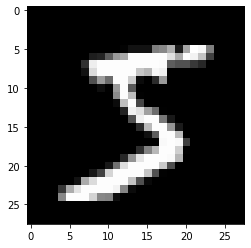

In [9]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0], cmap='gray')
plt.show()

이해를 위해서 첫번째 입력데이터의 이미지를 출력해 보겠습니다. 

## 데이터 전처리 (Data Preprocessing)

우리는 아직 2D 혹은 3D tensor로 이루어진 이미지를 직접 다루는 방법을 배우지 않았습니다. 즉 이미지를 직접 처리할 수는 없습니다. 이는 뒤에서 다룰 내용이구요. 이 예제에서는 각 각의 2D 이미지를 1D 벡터로 전환하여 기존에 배운 내용으로 손글씨 인식 모델을 만들겠습니다. 

이를 위하여 2D를 1D로 바꾸는 데이터전처리 과정을 거쳐야 합니다. 일전에 배웠떤 numpy 모듈의 `reshape` 함수를 이용하여 이 작업을 수행할 수 있습니다. 

In [10]:
x_train = x_train.reshape(-1, 28*28)

이렇게 해서, 우리는 1개의 속성을 가진 6만개의 개체를 훈련용 입력데이터로 만들었습니다. 

이어서 데이터정규화(normalization)을 진행하겠습니다. 
먼저 입력데이터의 값의 범위를 살펴볼까요? 

In [11]:
x_train.shape

(60000, 784)

In [ ]:
x_train[0]

각 픽셀의 값은 0부터 255까지의 정수 값을 갖으므로, 각 데이터의 값을 0~1사이의 값으로 변환하기 위해서는 **그냥 255로 나눠주면** 되겠네요. 단 데이터의 자료형을 정수가 아니라 **실수로 변환**해 줘야 합니다. 

물론, 기존에 배운 `sklearn.preprocessing`의 `MinMaxScaler()` 클래스를 사용해도 무방합니다. 

In [16]:
x_train = x_train.astype('float')/255

In [18]:
y_train[0]

5

출력데이터 역시 'one-hot encoding' 해서 10개의 속성으로 갖도록 변환하겠습니다. 

In [19]:
nb_claases = 10

In [25]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, nb_claases)

테스트용 데이터(x_test, y_test)에 대해서도 동일한 작업을 수행하고 전처리 과정을 마치도록 하겠습니다. 

In [26]:
x_test = x_test.reshape(-1, 28*28)
x_test = x_test.astype('float32')/255

In [27]:
y_test = np_utils.to_categorical(y_test, nb_claases)

In [28]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000, 10), (10000, 10))

## 모델 생성

우선 1개의 layer로만 구성된 모델을 만들어, 이후 만들 다중 layer로 구성된모델과의 성능 차이를 비교해 보겠습니다. 


In [92]:
model1 = Sequential()
#model1.add(Dense(units=nb_claases, activation='softmax', input_shape(784,)))
model1.add(Dense(units=nb_claases, activation='softmax', input_shape=(784,)))

와우~ 간단한 모델이지만, 훈련데이터에 대해 91%의 정확도를 갖네요. 

다음은 테스트데이터에 대한 이 모델의 성능을 확인해 보겠습니다. 
이때 keras의 `evaluate`라는 함수를 사용할 수 있습니다. 

In [87]:
model1.compile(optimizer=SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [88]:
model1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [89]:
history1 = model1.fit(x_train, y_train, epochs=15)

Epoch 1/15
60000/60000 [==============================] - 2s 34us/step - loss: 2.3015 - accuracy: 0.1124
Epoch 2/15
60000/60000 [==============================] - 2s 34us/step - loss: 2.3013 - accuracy: 0.1124
Epoch 3/15
60000/60000 [==============================] - 2s 35us/step - loss: 2.3013 - accuracy: 0.1124
Epoch 4/15
60000/60000 [==============================] - 2s 37us/step - loss: 2.3013 - accuracy: 0.1124
Epoch 5/15
60000/60000 [==============================] - 2s 37us/step - loss: 2.3013 - accuracy: 0.1124
Epoch 6/15
60000/60000 [==============================] - 2s 37us/step - loss: 2.3013 - accuracy: 0.1124
Epoch 7/15
60000/60000 [==============================] - 2s 38us/step - loss: 2.3013 - accuracy: 0.1124
Epoch 8/15
60000/60000 [==============================] - 2s 34us/step - loss: 2.3013 - accuracy: 0.1124
Epoch 9/15
60000/60000 [==============================] - 2s 34us/step - loss: 2.3013 - accuracy: 0.1124
Epoch 10/15
60000/60000 [==============================

In [71]:
score1 = model1.evaluate(x_test, y_test)

10000/10000 [==============================] - 0s 19us/step


In [72]:
score1[1]

0.15369999408721924

이제 조금 더 복잡한 네트워크 구조를 갖는 모델을 만들어 보겠습니다. 

여기서 몇가지 알고 계셔야 하는 것이 있습니다. 

* **Sequentail 모델에서는 모델의 층(layer)을 단순히 `add`로 쌓아가면 됩니다.** 
* **첫번째 layer에는 입력데이터의 모양 (`input_shape`)을 정의해야 합니다.** 
* **중간 layer에서의 `activation` 함수로는 여러가지를 쓸 수 있으나 일반적으로 'relu' 를 사용합니다.** 
* **마지막 layer는 문제의 목적에 맞게 (회귀?, 2진분류?, 다중분류?) `activation` 함수를 지정합니다.** 

중간 layer에서는 별도로 입력되는 데이터의 모양을 정의할 필요가 없습니다. 이전 layer의 출력 모양을 이미 모델이 알고 있기 때문입니다. 

중간 layer에서 activation 함수를 쓰는 이유는 중간층의 출력 결과가 너무 크거나 작아지는 것을 방지하기 위함이라고만 설명드리겠습니다. 일종의 정규화 작업과 비슷합니다. 

In [77]:
model2 = Sequential()
model2.add(Dense(units=256, activation='relu', input_shape=(784,)))
model2.add(Dense(units=256, activation='relu'))
model2.add(Dense(units=nb_claases, activation='softmax'))

In [78]:
model2.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_15 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


모델의 네트워크 구조를 요약해서 살펴보겠습니다. 

총 3개의 층으로 구성된 것을 알 수 있습니다. 

이제 모델을 compile 합니다. 일전과 동일하게, **손실함수**와 **optimizer**, 그리고 모니터링을 위한 **metrics 옵션**을 지정합니다. 

In [83]:
model2.compile(optimizer=SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

이제 model1과 동일하게 15 epoch 동안 학습을 진행하도록 하겠습니다. 

In [85]:
history2 = model2.fit(x_train, y_train, epochs=15)

Epoch 1/15
60000/60000 [==============================] - 6s 97us/step - loss: 2.3015 - accuracy: 0.1119
Epoch 2/15
60000/60000 [==============================] - 6s 97us/step - loss: 2.3013 - accuracy: 0.1124
Epoch 3/15
60000/60000 [==============================] - 6s 97us/step - loss: 2.3013 - accuracy: 0.1124
Epoch 4/15
60000/60000 [==============================] - 6s 97us/step - loss: 2.3013 - accuracy: 0.1124
Epoch 5/15
60000/60000 [==============================] - 6s 96us/step - loss: 2.3013 - accuracy: 0.1124
Epoch 6/15
60000/60000 [==============================] - 6s 97us/step - loss: 2.3013 - accuracy: 0.1124
Epoch 7/15
60000/60000 [==============================] - 6s 97us/step - loss: 2.3013 - accuracy: 0.1124
Epoch 8/15
60000/60000 [==============================] - 6s 97us/step - loss: 2.3013 - accuracy: 0.1124
Epoch 9/15
60000/60000 [==============================] - 6s 96us/step - loss: 2.3013 - accuracy: 0.1124
Epoch 10/15
60000/60000 [==============================

훈련데이터에 대해 model1 보다 월등한 성능을 보이는 군요. 

테스트데이터에 대한 성능은 어떨까요? 확인해 보겠습니다. 

In [90]:
score2 = model2.evaluate(x_test, y_test)

10000/10000 [==============================] - 0s 33us/step


In [91]:
score2[1]

0.08219999819993973

이제 여러분은 테스트 데이터에 대해서 약 97%의 정확도를 갖는 모델을 만들었습니다. 향후 여러분은 이미지 데이터 2D나 3D Tensor로 직접 처리하는 딥러닝 기법을 학습할 것이며, 이 경우 이 정확도는 99% 수준으로 높아질 수 있습니다. 하지만 여기서는 이정도 수준에서 만족하도록 하지요. 

학습과정 동안 훈련데이터에 대한 정확도의 변화를 살펴볼까요? 

Model2가 학습 초기부터 빠르게 학습하여 높은 정확도를 보이고 있음을 알 수 있습니다. 

이상으로 딥러닝의 기초적인 부분을 학습하였습니다. 

참고로 테스트데이터에서 10개의 숫자를 임의로 뽑아 제대로 예측하고 있는지 살펴보겠습니다. 